In [1]:
import networkx as nx
import cv2
import numpy as np
import scipy as sp
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, fsolve
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude, ENU_system
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.position_estimation import derive_position
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw, get_cliques_by_length
from craterdetection.common.conics import *



In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], ellipse_limit=1.2)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [3]:
resolution = (256, 256)

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 150

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

C:\dev\workspace\crater-detection\craterdetection\common\conics.py:150: UserWarning: No contour levels were found within the data range.
  ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors=rim_color)


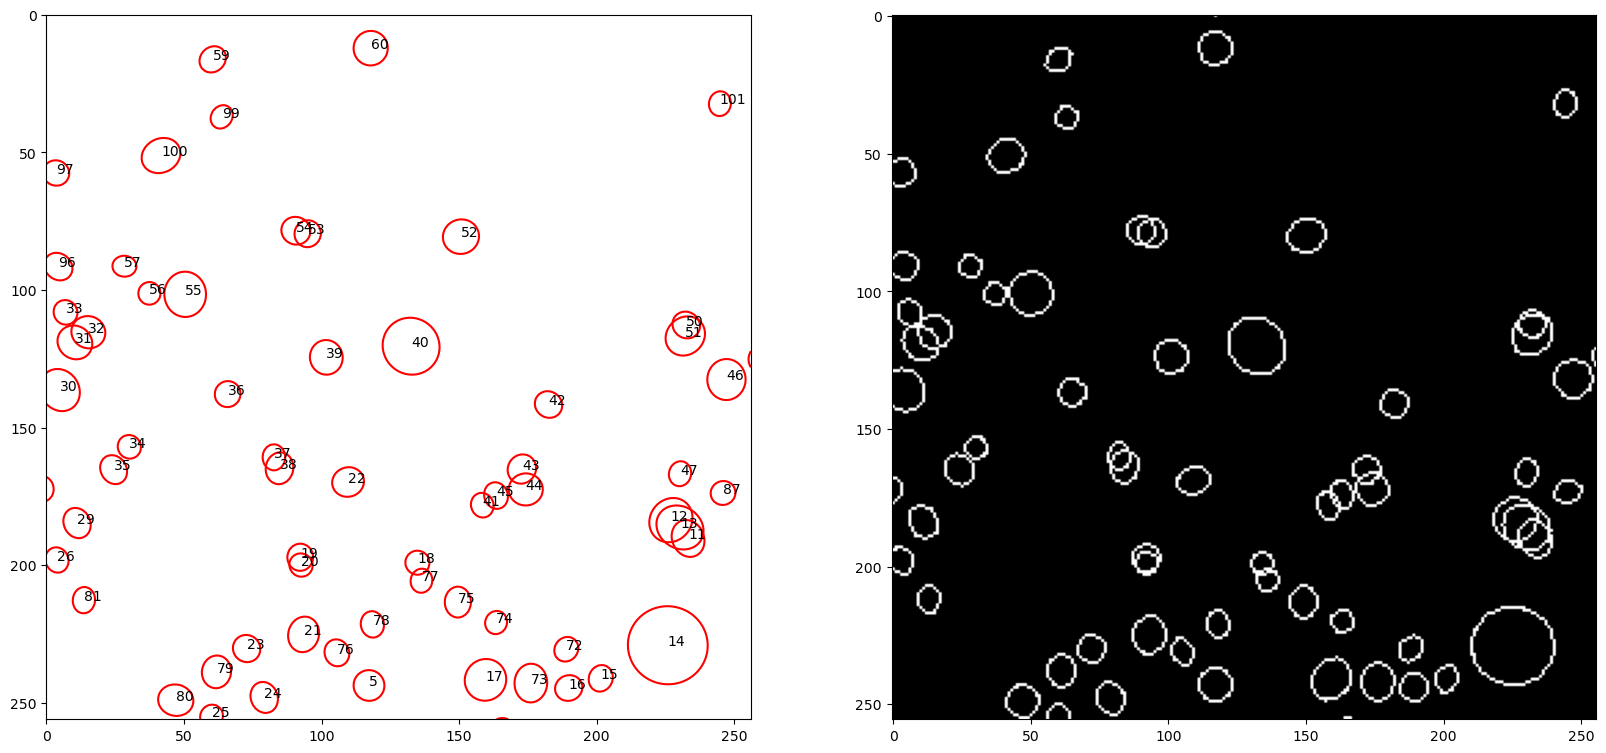

In [4]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = np.zeros(resolution)
for a_i in A_craters:
    center_coordinates = tuple(conic_center(a_i).astype(int))
    axes_length = map(round, ellipse_axes(a_i))
    angle = round(np.degrees(ellipse_angle(a_i)))
    img_ellipses = cv2.ellipse(img_ellipses, center_coordinates, tuple(axes_length),
                               angle, 0, 360, (255, 255, 255), 1)
    # img_ellipses = cv2.circle(img_ellipses, center_coordinates, 0, (255, 255, 255), 1)

axes[1].imshow(img_ellipses, cmap='Greys_r')
fig.savefig('output/crater_mask_example.pdf', bbox_inches = 'tight', pad_inches = 0)

In [5]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], latlims=[35, 55], longlims=[35, 55], radius=100)
# db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [6]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e1

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)

            subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=2)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)

                rank = np.where(np.sort(diff) == diff[match])[0].item()
                print(f"\tMean difference: {diff[match]:.2%}, position: "
                      f"{rank}")

                print("\tDetection feature: \t", features[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t",
                      lat_cat[vicinity][detection_order][crater_triad[order]],
                      long_cat[vicinity][detection_order][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[match]):
                    correct_matches[detection_idx] += [db_idx]
                print()
                break

    if i >= max_iter:
        break


MATCH [0]
[0 1 2]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.05%, position: 0
	Detection feature: 	 [ -61.798  -60.887  -10.173  -57.032  -38.827  -14.835 -244.834]
	DB match feature: 	 [ -61.76   -60.867  -10.17   -57.015  -38.79   -14.835 -244.609]
	Crater triad coords: 	 [0.786 0.774 0.788] [0.775 0.778 0.787]
	DB match coords: 	 [0.786 0.774 0.788] [0.775 0.778 0.787]

MATCH [4]
[13 12 14]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.19%, position: 0
	Detection feature: 	 [ -391.91    -89.192  -423.381  -423.334   -74.361  -467.149 -1865.969]
	DB match feature: 	 [ -390.963   -89.185  -422.248  -422.723   -74.301  -465.617 -1861.126]
	Crater triad coords: 	 [0.782 0.765 0.773] [0.761 0.788 0.803]
	DB match coords: 	 [0.782 0.765 0.773] [0.761 0.788 0.803]

MATCH [7]
[22 21 23]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.44%, position: 0
	Detection feature: 	 [ -177.934 -1312.511 -1781.579  -170.228 -1226.982 -1888.728 -6811.938]
	DB match feature: 	 [ -177.692 -1307.303 -1768.385  -17

In [108]:
%%time
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 100

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)
        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argmin(diff)

            for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[min_idx]):
                correct_matches[detection_idx] += [db_idx]
            break

    if i >= max_iter:
        break

Wall time: 3.24 s


In [8]:
for k, v in correct_matches.items():
    if len(v) >= 2:
        print(k, v)

In [110]:
order = np.empty((3, 3), np.int)
order_full = np.empty((3, 7), np.int)
for it, o_ in enumerate(cyclic_permutations(np.arange(3))):
    order[it] = o_
    order_full[it] = np.append(np.concatenate((o_, o_+3)), -1)

max_iter = 1
batch_size = 100
match_table = np.empty((max_iter, 2, batch_size, 3))

In [111]:
%%time
for i, (crater_triads, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order], batch_size=batch_size)):
    diff = np.mean(
        np.abs((db.features[:, None, None, :] - features[:, order_full][None, ...])/features[:, order_full][None, ...]),
        axis=-1
        )
    min_cyc_idx = diff.min(axis=0).argmin(axis=1)
    match_diff = diff.min(axis=0)[np.arange(len(min_cyc_idx)), min_cyc_idx]
    match_idx = diff.argmin(axis=0)[np.arange(len(min_cyc_idx)), min_cyc_idx]

    match_table[i, 0] = crater_triads[:, order[min_cyc_idx]][:, 0]
    match_table[i, 1] = db.crater_triads[match_idx]

    if i >= max_iter - 1:
        break
match_table

Wall time: 2.75 s


array([[[[  1.,   2.,   0.],
         [  4.,   5.,   3.],
         [  7.,   8.,   6.],
         [ 10.,  11.,   9.],
         [ 13.,  14.,  12.],
         [ 16.,  17.,  15.],
         [ 19.,  20.,  18.],
         [ 22.,  23.,  21.],
         [ 25.,  26.,  24.],
         [ 28.,  29.,  27.],
         [ 31.,  32.,  30.],
         [ 34.,  35.,  33.],
         [ 37.,  38.,  36.],
         [ 40.,  41.,  39.],
         [ 43.,  44.,  42.],
         [ 46.,  47.,  45.],
         [ 49.,  50.,  48.],
         [ 52.,  53.,  51.],
         [ 55.,  56.,  54.],
         [ 58.,  59.,  57.],
         [ 61.,  62.,  60.],
         [ 64.,  65.,  63.],
         [ 67.,  68.,  66.],
         [ 70.,  71.,  69.],
         [ 73.,  74.,  72.],
         [ 76.,  77.,  75.],
         [ 79.,  80.,  78.],
         [ 82.,  83.,  81.],
         [ 85.,  86.,  84.],
         [ 88.,  89.,  87.],
         [ 91.,  92.,  90.],
         [ 94.,  95.,  93.],
         [ 97.,  98.,  96.],
         [100., 101.,  99.],
         [  2.

In [10]:
np.set_printoptions(precision=5)
np.mean(np.abs((db.features[:, None, :] - features[None, ...])/features[None, ...]), axis=-1).min(axis=0)
np.mean(np.abs((db.features[:, None, :] - features[None, ...])/features[None, ...]), axis=-1).argmin(axis=0)

array([184956, 235562, 205763, 166554,  87641], dtype=int64)

In [11]:
diff = np.mean(np.abs((db.features[:, None, None, :] - features[:, order_full][None, ...])/features[:, order_full][None, ...]),
        axis=-1)
diff.min(axis=0)

array([[0.10431, 0.00049, 0.08152],
       [0.05076, 0.04747, 0.05682],
       [0.07396, 0.06296, 0.09385],
       [0.06412, 0.05488, 0.08206],
       [0.04639, 0.0019 , 0.04901]])

In [63]:
diff.argmin(axis=0)

array([[184956, 167303,  73337],
       [235562, 205148, 170462],
       [205763,  17267,  87715],
       [166554,  12141,  17809],
       [ 87641, 165860,  69767]], dtype=int64)

In [68]:
min_cyc_idx = diff.min(axis=0).argmin(axis=1)
match_diff = diff.min(axis=0)[np.arange(len(min_cyc_idx)), min_cyc_idx]
match_idx = diff.argmin(axis=0)[np.arange(len(min_cyc_idx)), min_cyc_idx]
match_diff, match_idx, order[min_cyc_idx]

In [81]:
db.crater_triads[match_idx]

array([[280, 253, 281],
       [331, 368, 386],
       [ 43,  15, 463],
       [ 13,  12, 116],
       [279, 250, 284]])

In [95]:
crater_triad[:, order[min_cyc_idx]][:, 0]

array([[ 1,  2,  0],
       [ 4,  5,  3],
       [ 7,  8,  6],
       [10, 11,  9],
       [13, 14, 12]])

In [112]:
match_diff

array([0.   , 0.047, 0.063, 0.055, 0.002, 0.054, 0.036, 0.004, 0.048,
       0.084, 0.038, 0.033, 0.039, 0.036, 0.117, 0.059, 0.04 , 0.123,
       0.12 , 0.034, 0.285, 0.044, 0.04 , 0.048, 0.176, 0.257, 0.035,
       0.065, 0.445, 0.093, 0.442, 0.44 , 0.224, 0.386, 0.001, 0.048,
       0.053, 0.02 , 0.001, 0.035, 0.034, 0.023, 0.087, 0.035, 0.086,
       0.041, 0.034, 0.048, 0.078, 0.075, 0.067, 0.133, 0.167, 0.055,
       0.381, 0.037, 0.116, 0.077, 0.298, 0.132, 0.137, 0.11 , 0.322,
       0.069, 0.433, 0.16 , 0.078, 0.048, 0.045, 0.1  , 0.003, 0.097,
       0.047, 0.039, 0.039, 0.042, 0.12 , 0.054, 0.035, 0.047, 0.049,
       0.084, 0.078, 0.04 , 0.082, 0.104, 0.076, 0.34 , 0.038, 0.094,
       0.242, 0.236, 0.2  , 0.11 , 0.215, 0.048, 0.111, 0.477, 0.065,
       0.433])